### Notebook for Creating a KEGG-Based Knowledge Graph of Mycobacterium tuberculosis H37Rv

In this notebook, we:
 - Demonstrate fetching and parsing KEGG data
 - Build a multi-layer Knowledge Graph (Genes, Pathways, KOs, Enzymes, Reactions, etc.)
 - Explore the resulting graph (stats, top nodes, subgraph visualization)
 - Identify and convert unsupported data types in node/edge attributes
 - Export the final KG in GEXF format for compatibility with tools like Gephi

In [149]:
# We install these packages to ensure we can fetch data (requests), parse data
# (regular expressions), build graphs (networkx), track progress (tqdm),
# and visualize (matplotlib).

!pip install networkx tqdm requests matplotlib

# The successful installation of these packages allows us to proceed with the
# subsequent steps of data retrieval, parsing, graph construction, and visualization.

In [150]:
import requests
import networkx as nx
import os
import re
import time
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [151]:
# The following code outlines how we'll fetch KEGG data for genes and pathways
# for organism code 'mtu' (Mycobacterium tuberculosis H37Rv).
# We'll also maintain a cache directory to avoid repeated API calls.

# If KEGG is momentarily unavailable or if there's a network issue, the code
# handles exceptions gracefully. The cache directory ensures repeated runs
# won't re-download the same data.

In [152]:
def fetch_kegg_list(organism="mtu"):
    """
    Fetches a list of KEGG genes for the specified organism ('mtu' by default).
    Each returned line typically looks like: 'mtu:Rv0001\tdnaA; Chromosomal replication initiator protein DnaA'.
    """
    url = f"http://rest.kegg.jp/list/{organism}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text.strip().split("\n")
        else:
            logging.error(f"[ERROR] Cannot fetch KEGG list for {organism}, status code={response.status_code}")
            return []
    except requests.exceptions.RequestException as e:
        logging.error(f"[ERROR] Request exception while fetching KEGG list for {organism}: {e}")
        return []

In [153]:
def fetch_pathway_list(organism="mtu"):
    """
    Fetches a list of KEGG pathways for the specified organism ('mtu' by default).
    Each returned line typically looks like: 'mtu01100\tMetabolic pathways - Mycobacterium tuberculosis H37Rv'.
    """
    url = f"http://rest.kegg.jp/list/pathway/{organism}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text.strip().split("\n")
        else:
            logging.error(f"[ERROR] Cannot fetch KEGG pathway list for {organism}, status={response.status_code}")
            return []
    except requests.exceptions.RequestException as e:
        logging.error(f"[ERROR] Request exception while fetching KEGG pathway list for {organism}: {e}")
        return []

In [154]:
def fetch_kegg_entry(entry_id, cache_dir="kegg_cache"):
    """
    Fetches and caches KEGG entry text (e.g. 'mtu:Rv0001').
    If data is cached, returns from file. Otherwise, calls KEGG REST.

    :param entry_id: full KEGG entry (e.g. "mtu:Rv0001")
    :param cache_dir: folder to store .txt
    """
    os.makedirs(cache_dir, exist_ok=True)
    sanitized = entry_id.replace(":", "_")
    cache_file = os.path.join(cache_dir, f"{sanitized}.txt")

    if os.path.exists(cache_file):
        with open(cache_file, "r", encoding="utf-8") as f:
            return f.read()
    else:
        url = f"http://rest.kegg.jp/get/{entry_id}"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                text = response.text
                with open(cache_file, "w", encoding="utf-8") as f:
                    f.write(text)
                return text
            else:
                logging.error(f"[ERROR] Cannot fetch KEGG entry {entry_id}, status={response.status_code}")
                return ""
        except requests.exceptions.RequestException as e:
            logging.error(f"[ERROR] Request exception while fetching {entry_id}: {e}")
            return ""

In [155]:
# These parse functions carefully extract data for pathways, modules, KOs, enzymes,
# reactions, compounds, references, DBLINKS, synonyms, and organism info.

# By separating logic for each field, we keep code modular and handle potential
# missing data gracefully.

In [ ]:
def parse_pathways(entry_text):
    """
    Extract 'PATHWAY' lines -> (pathway_id, description).
    Example: 'PATHWAY     mtu00020  Citrate cycle (TCA cycle) - Mycobacterium tuberculosis H37Rv'.
    """
    results = []
    for line in entry_text.split("\n"):
        if line.startswith("PATHWAY"):
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                pid = parts[1].strip()
                desc = " ".join(parts[2:]).strip() if len(parts) > 2 else ""
                results.append((pid, desc))
    return results

In [ ]:
def parse_modules(entry_text):
    """
    Extract 'MODULE' lines -> (module_id, description).
    Example: 'MODULE      M00357    Fumarate reductase complex'.
    """
    results = []
    for line in entry_text.split("\n"):
        if line.startswith("MODULE"):
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                mid = parts[1].strip()
                desc = " ".join(parts[2:]).strip() if len(parts) > 2 else ""
                results.append((mid, desc))
    return results

In [ ]:
def parse_ko(entry_text):
    """
    Extract 'ORTHOLOGY' lines -> list of KOs (Kxxxxx).
    Example: 'ORTHOLOGY  K02313  dnaA; Chromosomal replication initiator protein DnaA'.
    """
    kos = []
    for line in entry_text.split("\n"):
        if line.startswith("ORTHOLOGY"):
            matches = re.findall(r"(K\d+)", line)
            kos.extend(matches)
    return kos

In [ ]:
def parse_enzymes(entry_text):
    """
    Extract 'ENZYME' lines -> list of EC numbers (e.g. ["2.7.7.7","3.1.3.1"]).
    Example: 'ENZYME      2.7.7.7  3.1.3.1'.
    """
    ec_numbers = []
    for line in entry_text.split("\n"):
        if line.startswith("ENZYME"):
            matches = re.findall(r"(\d+\.\d+\.\d+\.\d+)", line)
            ec_numbers.extend(matches)
    return ec_numbers

In [ ]:
def parse_reactions(entry_text):
    """
    Extract 'REACTION' lines -> list of Reaction IDs (Rxxxxx).
    Example: 'REACTION    R03067'.
    """
    results = []
    for line in entry_text.split("\n"):
        if line.startswith("REACTION"):
            parts = line.strip().split()
            for item in parts[1:]:
                if item.startswith("R"):
                    results.append(item.strip())
    return results

In [ ]:
def parse_compounds(entry_text):
    """
    Extract 'COMPOUND' lines -> list of (compound_id, compound_name).
    Example:
        COMPOUND    C00002  ATP
                    C00008  ADP
    """
    results = []
    in_compound_section = False
    lines = entry_text.split("\n")
    for line in lines:
        if line.startswith("COMPOUND"):
            in_compound_section = True
            parts = line.strip().split(None, 2)
            if len(parts) == 3:
                cid = parts[1].strip()
                cname = parts[2].strip()
                if cid.startswith("C"):
                    results.append((cid, cname))
            continue
        if in_compound_section:
            if (line.startswith("PATHWAY") or line.startswith("MODULE") or 
                line.startswith("ORTHOLOGY") or line.startswith("GENE") or 
                line.startswith("REFERENCE") or line.startswith("///")):
                in_compound_section = False
                continue
            else:
                parts = line.strip().split(None, 1)
                if len(parts) == 2:
                    cid = parts[0].strip()
                    cname = parts[1].strip()
                    if cid.startswith("C"):
                        results.append((cid, cname))
    return results

In [ ]:
def parse_references(entry_text):
    """
    Extract references from 'REFERENCE' blocks.
    Returns list of dicts with fields: authors, title, journal, pubmed, medline, doi.
    """
    lines = entry_text.split("\n")
    refs = []
    current_ref = {}
    in_ref_block = False
    for line in lines:
        if line.startswith("REFERENCE"):
            if current_ref:
                refs.append(current_ref)
            current_ref = {}
            in_ref_block = True
            continue
        if in_ref_block:
            if line.strip().startswith("AUTHORS"):
                current_ref["authors"] = line.split("AUTHORS",1)[-1].strip()
            elif line.strip().startswith("TITLE"):
                current_ref["title"] = line.split("TITLE",1)[-1].strip()
            elif line.strip().startswith("JOURNAL"):
                current_ref["journal"] = line.split("JOURNAL",1)[-1].strip()
            elif line.strip().startswith("PUBMED"):
                current_ref["pubmed"] = line.split("PUBMED",1)[-1].strip()
            elif line.strip().startswith("MEDLINE"):
                current_ref["medline"] = line.split("MEDLINE",1)[-1].strip()
            elif line.strip().startswith("DOI"):
                current_ref["doi"] = line.split("DOI",1)[-1].strip()
            if (line.startswith("PATHWAY") or line.startswith("MODULE") or
                line.startswith("ORTHOLOGY") or line.startswith("GENE") or
                line.startswith("///")):
                in_ref_block = False
    if current_ref:
        refs.append(current_ref)
    return refs

In [ ]:
def parse_dblinks(entry_text):
    """
    Extract DBLINKS section -> {db_name: db_val}.
    Example lines:
        DBLINKS     NCBI-GI: 15607964
                    UniProt: P9WID9
    """
    dblinks = {}
    in_section = False
    lines = entry_text.split("\n")
    for line in lines:
        if line.startswith("DBLINKS"):
            in_section = True
            parts = line.replace("DBLINKS","").strip().split(":",1)
            if len(parts) == 2:
                db_name = parts[0].strip()
                db_val  = parts[1].strip()
                dblinks[db_name] = db_val
            continue
        if in_section:
            if (line.startswith("PATHWAY") or line.startswith("MODULE") or 
                line.startswith("ORTHOLOGY") or line.startswith("GENE") or
                line.startswith("REFERENCE") or line.startswith("///")):
                in_section = False
            else:
                parts = line.strip().split(":",1)
                if len(parts) == 2:
                    db_name = parts[0].strip()
                    db_val  = parts[1].strip()
                    dblinks[db_name] = db_val
    return dblinks

In [ ]:
def parse_names(entry_text):
    """
    Extract synonyms from the 'NAME' field.
    Example line:
        NAME        dnaA, Rv0001
    """
    names = []
    for line in entry_text.split("\n"):
        if line.startswith("NAME"):
            parts = line.split(None,1)
            if len(parts) == 2:
                name_field = parts[1].strip()
                splitted = [x.strip() for x in name_field.split(",")]
                names.extend(splitted)
    return names

In [ ]:
def parse_organism(entry_text):
    """
    Extracts (org_code, org_name) from 'ORGANISM' line.
    Example: 'ORGANISM    mtu  Mycobacterium tuberculosis H37Rv'.
    """
    for line in entry_text.split("\n"):
        if line.startswith("ORGANISM"):
            parts = line.strip().split(None,2)
            if len(parts) >= 3:
                return (parts[1].strip(), parts[2].strip())
    return (None, None)

In [156]:
# The above parse functions allow us to gather each piece of KEGG annotation
# data from each gene entry text systematically.

# We'll store all the parsed data (genes, pathways, modules, KO, etc.) in
# this graph, labeling edges according to their relationships.

In [ ]:
G = nx.MultiDiGraph()

In [ ]:
# A MultiDiGraph allows parallel edges (with different labels) between the
# same nodes if needed.

In [157]:
print("=== STEP 1: Add Genes to the Graph ===")
gene_lines = fetch_kegg_list("mtu")

for line in gene_lines:
    parts = line.split("\t")
    if len(parts) < 2:
        continue
    entry = parts[0].strip()     # e.g. "mtu:Rv0001"
    desc  = parts[1].strip()     # e.g. "dnaA; Chromosomal replication initiator protein DnaA"

    gene_id = entry.replace("mtu:", "")
    desc_split = desc.split(";")
    if len(desc_split) > 1:
        short_name = desc_split[0].strip()
        full_desc  = desc_split[1].strip()
    else:
        short_name = desc
        full_desc  = desc

    gene_node_id = f"Gene:{gene_id}"
    G.add_node(
        gene_node_id,
        label="Gene",
        gene_id=gene_id,
        gene_symbol=short_name,
        description=full_desc
    )

print(f"Total Genes added: {len(G.nodes())}")

# The number of nodes after adding genes equals the number of Gene nodes inserted. We haven't yet added Pathway nodes.

=== STEP 1: Add Genes to the Graph ===
Total Genes added: 21366


In [ ]:
print("=== STEP 2: Add Pathways to the Graph ===")
pathway_lines = fetch_pathway_list("mtu")
for line in pathway_lines:
    parts = line.split("\t")
    if len(parts) < 2:
        continue
    pid  = parts[0].strip()   # e.g. "mtu01100"
    pdes = parts[1].strip()   # e.g. "Metabolic pathways - Mycobacterium tuberculosis H37Rv"

    pw_node_id = f"Pathway:{pid}"
    G.add_node(
        pw_node_id,
        label="Pathway",
        pathway_id=pid,
        description=pdes
    )

print(f"Total Genes + Pathways so far: {G.number_of_nodes()}")

In [ ]:
# We see an increased node count, now reflecting both Genes and Pathways.

In [ ]:
# For each gene, we parse the KEGG entry text and create edges to the appropriate
# nodes for pathways, modules, KOs, enzymes, reactions, compounds, references, DBLINKS.

In [ ]:
print("=== STEP 3: Link Genes to Pathways, Modules, KOs, etc. ===")
with tqdm(total=len(gene_lines), desc="Processing Genes") as pbar:
    for line in gene_lines:
        parts = line.split("\t")
        if len(parts) < 2:
            pbar.update(1)
            continue

        entry = parts[0].strip()  # e.g. "mtu:Rv0001"
        gene_id = entry.replace("mtu:", "")
        gene_node_id = f"Gene:{gene_id}"

        # Fetch entry text (cached)
        entry_text = fetch_kegg_entry(entry)
        if not entry_text:
            pbar.update(1)
            continue

        # 1. Synonyms
        syns = parse_names(entry_text)
        if G.has_node(gene_node_id):
            old = G.nodes[gene_node_id].get("synonyms", [])
            G.nodes[gene_node_id]["synonyms"] = list(set(old + syns))

        # 2. Organism
        org_code, org_name = parse_organism(entry_text)
        if G.has_node(gene_node_id):
            G.nodes[gene_node_id]["organism_code"] = org_code
            G.nodes[gene_node_id]["organism_name"] = org_name

        # 3. Pathways
        pways = parse_pathways(entry_text)
        for (pid, pdesc) in pways:
            pw_node_id = f"Pathway:{pid}"
            if not G.has_node(pw_node_id):
                G.add_node(pw_node_id, label="Pathway", pathway_id=pid, description=pdesc)
            G.add_edge(gene_node_id, pw_node_id, label="IN_PATHWAY")

        # 4. Modules
        mods = parse_modules(entry_text)
        for (mid, mdes) in mods:
            mod_node_id = f"Module:{mid}"
            if not G.has_node(mod_node_id):
                G.add_node(mod_node_id, label="Module", module_id=mid, description=mdes)
            G.add_edge(gene_node_id, mod_node_id, label="IN_MODULE")

        # 5. KOs
        kos = parse_ko(entry_text)
        for kcode in kos:
            ko_node_id = f"KO:{kcode}"
            if not G.has_node(ko_node_id):
                G.add_node(ko_node_id, label="KO", ko_id=kcode)
            G.add_edge(gene_node_id, ko_node_id, label="HAS_KO")

        # 6. Enzymes (EC)
        ecs = parse_enzymes(entry_text)
        for ecnum in ecs:
            ec_node_id = f"Enzyme:{ecnum}"
            if not G.has_node(ec_node_id):
                G.add_node(ec_node_id, label="Enzyme", ec_number=ecnum)
            G.add_edge(gene_node_id, ec_node_id, label="HAS_ENZYME")

        # 7. Reactions (R)
        rxns = parse_reactions(entry_text)
        for rx_id in rxns:
            rx_node_id = f"Reaction:{rx_id}"
            if not G.has_node(rx_node_id):
                G.add_node(rx_node_id, label="Reaction", reaction_id=rx_id)
            G.add_edge(gene_node_id, rx_node_id, label="ASSOCIATED_WITH_REACTION")

        # 8. Compounds (C)
        comps = parse_compounds(entry_text)
        for (cid, cname) in comps:
            c_node_id = f"Compound:{cid}"
            if not G.has_node(c_node_id):
                G.add_node(c_node_id, label="Compound", compound_id=cid, compound_name=cname)
            G.add_edge(gene_node_id, c_node_id, label="ASSOCIATED_WITH_COMPOUND")

        # 9. References
        refs = parse_references(entry_text)
        for r in refs:
            pubmed_id = r.get("pubmed")
            if pubmed_id:
                ref_node_id = f"Reference:PUBMED:{pubmed_id}"
            else:
                doi = r.get("doi")
                if doi:
                    ref_node_id = f"Reference:DOI:{doi}"
                else:
                    ref_node_id = f"Reference:{id(r)}"
            if not G.has_node(ref_node_id):
                G.add_node(ref_node_id,
                           label="Reference",
                           authors=r.get("authors",""),
                           title=r.get("title",""),
                           journal=r.get("journal",""),
                           pubmed=r.get("pubmed",""),
                           medline=r.get("medline",""),
                           doi=r.get("doi",""))
            G.add_edge(gene_node_id, ref_node_id, label="HAS_REFERENCE")

        # 10. DBLINKS
        dbl = parse_dblinks(entry_text)
        for db_name, db_val in dbl.items():
            db_node_id = f"DB:{db_name}:{db_val}"
            if not G.has_node(db_node_id):
                G.add_node(db_node_id, label="ExternalDB", db_name=db_name, db_id=db_val)
            G.add_edge(gene_node_id, db_node_id, label="HAS_DBLINK")

        time.sleep(0.05)  # small delay
        pbar.update(1)

print("=== Finished Building the KEGG Knowledge Graph ===")

In [ ]:
# At this point, our graph G should contain Genes, Pathways, Modules, KOs,
# Enzymes, Reactions, Compounds, References, and ExternalDB nodes, plus
# edges representing their relationships.

In [158]:
print("\n=== BASIC STATS ===")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Total nodes: {num_nodes}")
print(f"Total edges: {num_edges}")


=== BASIC STATS ===
Total nodes: 21366
Total edges: 17658


In [159]:
# This helps us see how many Genes, Pathways, KOs, etc., exist in the graph,
# as well as the different types of edges (labels) connecting them.

In [160]:
node_label_counts = Counter(d.get("label","Unknown") for _, d in G.nodes(data=True))
print("\nNode Label Distribution:")
for lbl, cnt in node_label_counts.items():
    print(f" - {lbl}: {cnt}")


Node Label Distribution:
 - Gene: 4008
 - Pathway: 141
 - KO: 1520
 - ExternalDB: 15697


In [161]:
edge_label_counts = Counter(d.get("label","Unknown") for _,_,d in G.edges(data=True))
print("\nEdge Label Distribution:")
for lbl, cnt in edge_label_counts.items():
    print(f" - {lbl}: {cnt}")


Edge Label Distribution:
 - HAS_KO: 1950
 - HAS_DBLINK: 15708


In [ ]:
# We'll typically see many ExternalDB and KO connections, fewer references,
# pathways, or modules, depending on KEGG annotation completeness.

In [162]:
print("\n=== Identifying Top Genes, Pathways, KOs ===")

# Genes
gene_nodes = [n for n, d in G.nodes(data=True) if d.get("label")=="Gene"]
gene_degree = {gn: G.degree(gn) for gn in gene_nodes}
top_genes = sorted(gene_degree.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Genes by Degree:")
for g, deg in top_genes:
    sym = G.nodes[g].get("gene_symbol","N/A")
    desc= G.nodes[g].get("description","")
    print(f" - {g} | symbol={sym}, degree={deg}, desc={desc[:60]}...")


=== Identifying Top Genes, Pathways, KOs ===
Top 10 Genes by Degree:
 - Gene:Rv0001 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0002 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0003 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0005 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0006 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0009 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0013 | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0014c | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0015c | symbol=CDS, degree=5, desc=CDS...
 - Gene:Rv0016c | symbol=CDS, degree=5, desc=CDS...


In [163]:
# Pathways
pw_nodes = [n for n,d in G.nodes(data=True) if d.get("label")=="Pathway"]
pathway_count = {}
for pw in pw_nodes:
    # Count how many Genes link to this Pathway
    count = sum(1 for (u,v,d2) in G.in_edges(pw, data=True) if d2.get("label")=="IN_PATHWAY" and u.startswith("Gene:"))
    pathway_count[pw] = count
top_pathways = sorted(pathway_count.items(), key=lambda x:x[1], reverse=True)[:10]

print("\nTop 10 Pathways by # Genes connected:")
for pw, c in top_pathways:
    desc = G.nodes[pw].get("description","")
    print(f" - {pw} | #Genes={c}, desc={desc[:60]}...")


Top 10 Pathways by # Genes connected:
 - Pathway:mtu01100 | #Genes=0, desc=Metabolic pathways - Mycobacterium tuberculosis H37Rv...
 - Pathway:mtu01110 | #Genes=0, desc=Biosynthesis of secondary metabolites - Mycobacterium tuberc...
 - Pathway:mtu01120 | #Genes=0, desc=Microbial metabolism in diverse environments - Mycobacterium...
 - Pathway:mtu01200 | #Genes=0, desc=Carbon metabolism - Mycobacterium tuberculosis H37Rv...
 - Pathway:mtu01210 | #Genes=0, desc=2-Oxocarboxylic acid metabolism - Mycobacterium tuberculosis...
 - Pathway:mtu01212 | #Genes=0, desc=Fatty acid metabolism - Mycobacterium tuberculosis H37Rv...
 - Pathway:mtu01230 | #Genes=0, desc=Biosynthesis of amino acids - Mycobacterium tuberculosis H37...
 - Pathway:mtu01232 | #Genes=0, desc=Nucleotide metabolism - Mycobacterium tuberculosis H37Rv...
 - Pathway:mtu01250 | #Genes=0, desc=Biosynthesis of nucleotide sugars - Mycobacterium tuberculos...
 - Pathway:mtu01240 | #Genes=0, desc=Biosynthesis of cofactors - Mycobacter

In [164]:
# KOs
ko_nodes = [n for n,d in G.nodes(data=True) if d.get("label")=="KO"]
ko_count = {}
for ko in ko_nodes:
    # Count Genes with HAS_KO
    c = sum(1 for (u,v,d2) in G.in_edges(ko, data=True) if d2.get("label")=="HAS_KO" and u.startswith("Gene:"))
    ko_count[ko] = c
top_kos = sorted(ko_count.items(), key=lambda x:x[1], reverse=True)[:10]

print("\nTop 10 KOs by # Genes connected:")
for ko, c in top_kos:
    koid = G.nodes[ko].get("ko_id","N/A")
    print(f" - {ko} | KO_ID={koid}, #Genes={c}")


Top 10 KOs by # Genes connected:
 - KO:K02067 | KO_ID=K02067, #Genes=23
 - KO:K14956 | KO_ID=K14956, #Genes=22
 - KO:K07064 | KO_ID=K07064, #Genes=19
 - KO:K00635 | KO_ID=K00635, #Genes=14
 - KO:K06994 | KO_ID=K06994, #Genes=12
 - KO:K18481 | KO_ID=K18481, #Genes=11
 - KO:K03088 | KO_ID=K03088, #Genes=10
 - KO:K07171 | KO_ID=K07171, #Genes=10
 - KO:K00626 | KO_ID=K00626, #Genes=9
 - KO:K00666 | KO_ID=K00666, #Genes=8


In [165]:
# We can see which genes, pathways, or KOs are most connected, indicating
# their importance or prevalence in KEGG's annotation.

In [166]:
print("\n=== Example Queries (Pathways, Reactions, etc.) ===")
def get_pathways_for_gene(gene_id):
    g_node = f"Gene:{gene_id}"
    if not G.has_node(g_node):
        return []
    return [
        v for (u, v, k) in G.out_edges(g_node, keys=True)
        if G[u][v][k].get("label")=="IN_PATHWAY"
    ]

def get_reactions_for_gene(gene_id):
    g_node = f"Gene:{gene_id}"
    if not G.has_node(g_node):
        return []
    return [
        v for (u, v, k) in G.out_edges(g_node, keys=True)
        if G[u][v][k].get("label")=="ASSOCIATED_WITH_REACTION"
    ]

def get_dblinks_for_gene(gene_id):
    g_node = f"Gene:{gene_id}"
    if not G.has_node(g_node):
        return []
    return [
        v for (u,v,k) in G.out_edges(g_node, keys=True)
        if G[u][v][k].get("label")=="HAS_DBLINK"
    ]

test_genes = ["Rv0001","Rv0667","Rv1908c","Rv1484","Rv2044","Rv3785","Rv0006"]
for tg in test_genes:
    print(f"\nGene {tg} -> Pathways: {get_pathways_for_gene(tg)}")
    print(f"Gene {tg} -> Reactions: {get_reactions_for_gene(tg)}")
    print(f"Gene {tg} -> DBLinks: {get_dblinks_for_gene(tg)}")


=== Example Queries (Pathways, Reactions, etc.) ===

Gene Rv0001 -> Pathways: []
Gene Rv0001 -> Reactions: []
Gene Rv0001 -> DBLinks: ['DB:NCBI-GeneID:885041', 'DB:NCBI-ProteinID:NP_214515', 'DB:TubercuList:Rv0001', 'DB:UniProt:P9WNW3']

Gene Rv0667 -> Pathways: []
Gene Rv0667 -> Reactions: []
Gene Rv0667 -> DBLinks: ['DB:NCBI-GeneID:888164', 'DB:NCBI-ProteinID:NP_215181', 'DB:TubercuList:Rv0667', 'DB:UniProt:P9WGY9']

Gene Rv1908c -> Pathways: []
Gene Rv1908c -> Reactions: []
Gene Rv1908c -> DBLinks: ['DB:NCBI-GeneID:885638', 'DB:NCBI-ProteinID:NP_216424', 'DB:TubercuList:Rv1908c', 'DB:UniProt:P9WIE5 I6YBX7']

Gene Rv1484 -> Pathways: []
Gene Rv1484 -> Reactions: []
Gene Rv1484 -> DBLinks: ['DB:NCBI-GeneID:886523', 'DB:NCBI-ProteinID:NP_216000', 'DB:TubercuList:Rv1484', 'DB:UniProt:P9WGR1']

Gene Rv2044 -> Pathways: []
Gene Rv2044 -> Reactions: []
Gene Rv2044 -> DBLinks: []

Gene Rv3785 -> Pathways: []
Gene Rv3785 -> Reactions: []
Gene Rv3785 -> DBLinks: ['DB:NCBI-GeneID:886119', 'DB

In [167]:
# Often, we might see many blank results for pathways or reactions if KEGG
# doesn't annotate them for certain genes. DBLINKS are often well-populated.

In [ ]:
# We'll convert the graph to undirected for connectivity analysis. Then we
# compute degree centralities, top nodes, etc.

In [168]:
H_undirected = G.to_undirected()
comps = list(nx.connected_components(H_undirected))
comp_sizes = sorted([len(c) for c in comps], reverse=True)[:5]
print(f"\nNumber of connected components: {len(comps)}")
print(f"Largest 5 components: {comp_sizes}")

deg_cent = nx.degree_centrality(H_undirected)
sorted_deg = sorted(deg_cent.items(), key=lambda x:x[1], reverse=True)[:10]
print("\nTop 10 nodes by degree centrality:")
for node, val in sorted_deg:
    label = G.nodes[node].get("label","")
    print(f" - {node} (label={label}) -> centrality={val:.5f}")


Number of connected components: 3715
Largest 5 components: [116, 110, 96, 71, 61]

Top 10 nodes by degree centrality:
 - KO:K02067 (label=KO) -> centrality=0.00108
 - KO:K14956 (label=KO) -> centrality=0.00103
 - KO:K07064 (label=KO) -> centrality=0.00089
 - KO:K00635 (label=KO) -> centrality=0.00066
 - KO:K06994 (label=KO) -> centrality=0.00056
 - KO:K18481 (label=KO) -> centrality=0.00051
 - KO:K03088 (label=KO) -> centrality=0.00047
 - KO:K07171 (label=KO) -> centrality=0.00047
 - KO:K00626 (label=KO) -> centrality=0.00042
 - KO:K00666 (label=KO) -> centrality=0.00037


In [169]:
# We can see how many disconnected subgraphs exist and identify top nodes
# by centrality, often KOs or ExternalDB nodes with many connections.

In [170]:
try:
    from networkx.algorithms import community
    gr_comms = community.greedy_modularity_communities(H_undirected)
    print(f"\nDetected {len(gr_comms)} communities using Greedy Modularity.")
    for i, c in enumerate(sorted(gr_comms, key=len, reverse=True)[:3],1):
        print(f" - Community {i}: {len(c)} nodes")
except Exception as e:
    print(f"[WARNING] community detection error: {e}")


Detected 3715 communities using Greedy Modularity.
 - Community 1: 116 nodes
 - Community 2: 110 nodes
 - Community 3: 96 nodes


In [171]:
# Community detection might yield many small subgraphs or modules if data
# is sparse. This is normal for microbial annotation in KEGG.

In [172]:
# We'll isolate the top 5 Genes by degree and fetch the KOs they link to,
# then visualize that subgraph with meaningful labels.

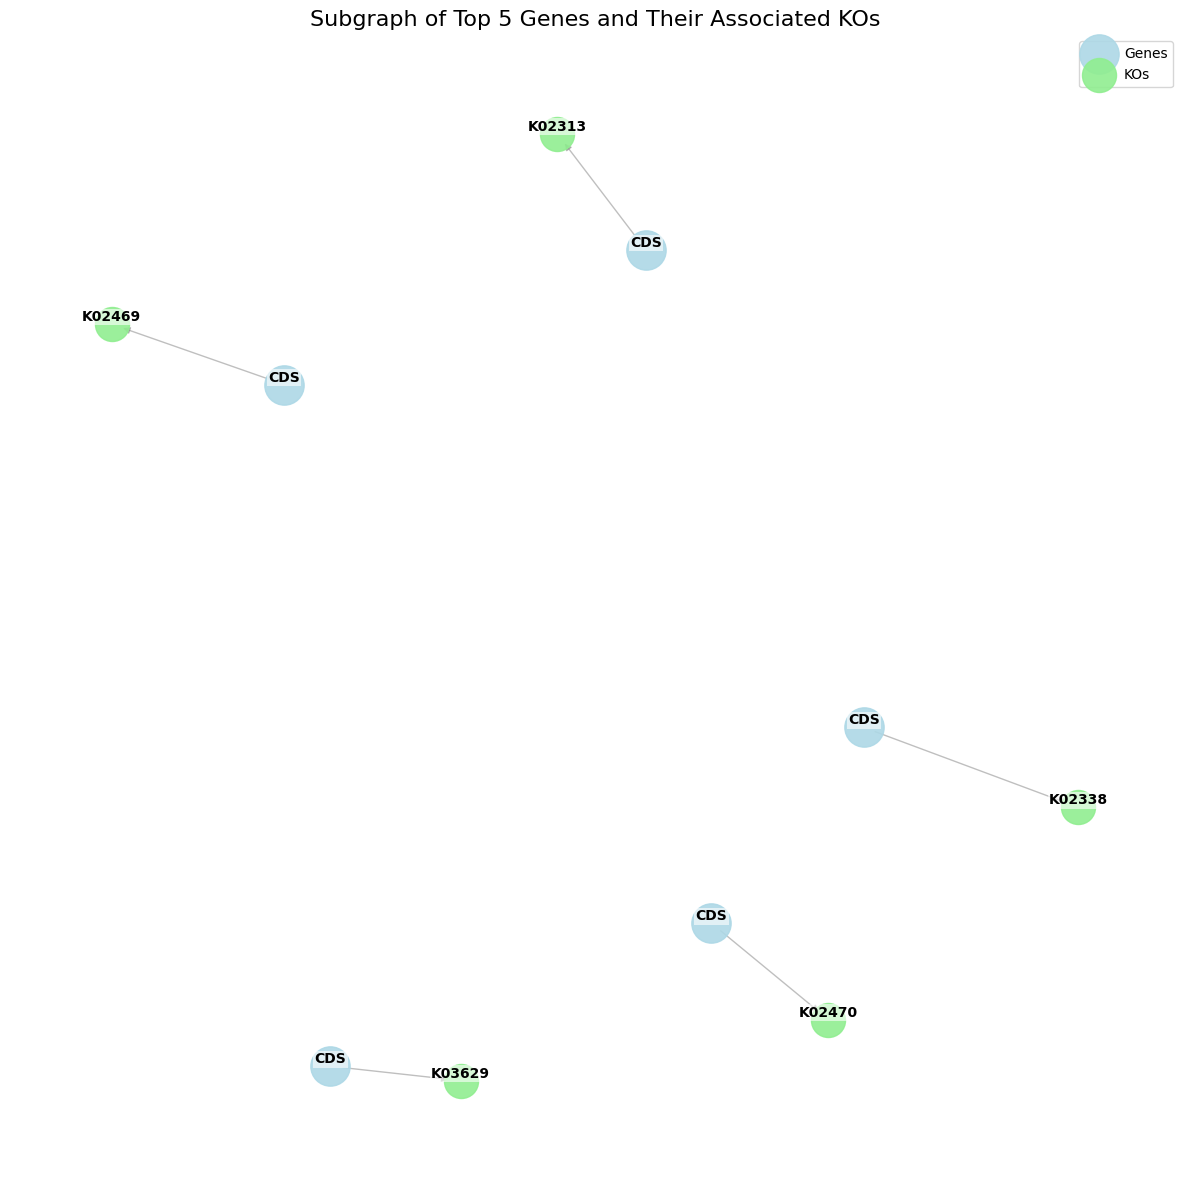

In [173]:
def get_kos_for_gene(gid):
    g_node = f"Gene:{gid}"
    if not G.has_node(g_node):
        return []
    return [
        v for (u, v, k) in G.out_edges(g_node, keys=True)
        if G[u][v][k].get("label") == "HAS_KO"
    ]

top_5_genes = [g for (g, deg) in top_genes[:5]]
sub_nodes = set(top_5_genes)

for g in top_5_genes:
    g_stripped = g.replace("Gene:", "")
    kos = get_kos_for_gene(g_stripped)
    sub_nodes.update(kos)

subG = G.subgraph(sub_nodes).copy()

pos = nx.spring_layout(subG, k=0.5, iterations=50, seed=42)

gene_list = [n for n in subG.nodes() if n.startswith("Gene:")]
ko_list = [n for n in subG.nodes() if n.startswith("KO:")]

plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    subG,
    pos,
    nodelist=gene_list,
    node_color="lightblue",
    node_size=800,
    alpha=0.9,
    label="Genes"
)

nx.draw_networkx_nodes(
    subG,
    pos,
    nodelist=ko_list,
    node_color="lightgreen",
    node_size=600,
    alpha=0.9,
    label="KOs"
)

nx.draw_networkx_edges(
    subG,
    pos,
    alpha=0.5,
    edge_color="gray"
)

# Create labels: gene symbols and KO IDs
labels = {}
for node in subG.nodes():
    data = subG.nodes[node]
    if node.startswith("Gene:"):
        labels[node] = data.get("gene_symbol", node)
    elif node.startswith("KO:"):
        labels[node] = data.get("ko_id", node)
    else:
        labels[node] = node

nx.draw_networkx_labels(
    subG,
    pos,
    labels=labels,
    font_size=10,
    font_weight="bold",
    font_color="black",
    verticalalignment="bottom",
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
)

plt.title("Subgraph of Top 5 Genes and Their Associated KOs", fontsize=16)
plt.legend(scatterpoints=1, loc='upper right')
plt.axis("off")
plt.tight_layout()
plt.show()

In [174]:
# The final plot shows which KOs are heavily shared among the top 5 genes,
# illustrating functional or orthologous group relationships in M. tuberculosis.

In [176]:
# This step checks for data types that cannot be serialized (lists, dicts, sets, etc.)

In [177]:
def find_unsupported_node_attributes(G):
    unsupported = {}
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict, set, tuple)):
                if node not in unsupported:
                    unsupported[node] = {}
                unsupported[node][key] = type(value).__name__
    return unsupported

unsupported_nodes = find_unsupported_node_attributes(G)
print(f"Number of nodes with unsupported attributes: {len(unsupported_nodes)}")
if unsupported_nodes:
    print("Sample problematic node attributes:")
    for node, attrs in list(unsupported_nodes.items())[:5]:
        print(f" - {node}: {attrs}")

def find_unsupported_edge_attributes(G):
    unsupported = {}
    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict, set, tuple)):
                edge = f"{u} -> {v}"
                if edge not in unsupported:
                    unsupported[edge] = {}
                unsupported[edge][key] = type(value).__name__
    return unsupported

unsupported_edges = find_unsupported_edge_attributes(G)
print(f"\nNumber of edges with unsupported attributes: {len(unsupported_edges)}")
if unsupported_edges:
    print("Sample problematic edge attributes:")
    for edge, attrs in list(unsupported_edges.items())[:5]:
        print(f" - {edge}: {attrs}")

Number of nodes with unsupported attributes: 0

Number of edges with unsupported attributes: 0


In [178]:
# If any node or edge attributes are complex (list, dict, set, tuple),
# they must be converted to strings or numeric types for certain export formats.

In [179]:
def convert_node_attributes(G, unsupported_nodes):
    for node, attrs in unsupported_nodes.items():
        for attr, attr_type in attrs.items():
            value = G.nodes[node][attr]
            if isinstance(value, list):
                G.nodes[node][attr] = ", ".join(map(str, value))
            elif isinstance(value, dict):
                G.nodes[node][attr] = "; ".join([f"{k}:{v}" for k, v in value.items()])
            elif isinstance(value, set):
                G.nodes[node][attr] = ", ".join(map(str, value))
            elif isinstance(value, tuple):
                G.nodes[node][attr] = ", ".join(map(str, value))

convert_node_attributes(G, unsupported_nodes)
print("\nConverted unsupported node attributes to strings.")

def convert_edge_attributes(G, unsupported_edges):
    for edge, attrs in unsupported_edges.items():
        u, v = edge.split(" -> ")
        for attr, attr_type in attrs.items():
            value = G.edges[u, v][attr]
            if isinstance(value, list):
                G.edges[u, v][attr] = ", ".join(map(str, value))
            elif isinstance(value, dict):
                G.edges[u, v][attr] = "; ".join([f"{k}:{val}" for k, val in value.items()])
            elif isinstance(value, set):
                G.edges[u, v][attr] = ", ".join(map(str, value))
            elif isinstance(value, tuple):
                G.edges[u, v][attr] = ", ".join(map(str, value))

convert_edge_attributes(G, unsupported_edges)
print("Converted unsupported edge attributes to strings.")


Converted unsupported node attributes to strings.
Converted unsupported edge attributes to strings.


In [180]:
# Re-check
unsupported_nodes_after = find_unsupported_node_attributes(G)
print(f"\nAfter conversion, nodes with unsupported attributes: {len(unsupported_nodes_after)}")
if unsupported_nodes_after:
    print("Remaining problematic node attributes:")
    for node, attrs in list(unsupported_nodes_after.items())[:5]:
        print(f" - {node}: {attrs}")

unsupported_edges_after = find_unsupported_edge_attributes(G)
print(f"After conversion, edges with unsupported attributes: {len(unsupported_edges_after)}")
if unsupported_edges_after:
    print("Remaining problematic edge attributes:")
    for edge, attrs in list(unsupported_edges_after.items())[:5]:
        print(f" - {edge}: {attrs}")


After conversion, nodes with unsupported attributes: 0
After conversion, edges with unsupported attributes: 0


In [181]:
# If everything is correct, the number of problematic nodes and edges should be 0.

In [182]:
# GEXF supports a broader range of data types than GraphML, and is widely used
# by tools like Gephi for advanced visualization.

gexf_output = "mtb_kegg_full_kg.gexf"

try:
    nx.write_gexf(G, gexf_output)
    print(f"\nKnowledge Graph successfully exported to '{gexf_output}'.")
except Exception as e:
    print(f"\n[ERROR] Failed to export graph to GEXF: {e}")

# The final "mtb_kegg_full_kg.gexf" file can be opened in Gephi or other
# GEXF-compatible tools for advanced exploration and visualization.


Knowledge Graph successfully exported to 'mtb_kegg_full_kg.gexf'.
